In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# !rm -r pascal_voc

In [3]:
!mkdir -p pascal_voc/model

# Config


In [4]:
import torch
import cv2
import os
import albumentations as A

from albumentations.pytorch import ToTensorV2


DATASET = '../input/PASCAL_VOC'
DEVICE = 'cuda'
# seed_everything()  # If you want deterministic behavior
NUM_WORKERS = 8
BATCH_SIZE = 16
IMAGE_SIZE = 416
NUM_CLASSES = 20
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 1e-4
NUM_EPOCHS = 61
CONF_THRESHOLD = 0.4
MAP_IOU_THRESH = 0.5
NMS_IOU_THRESH = 0.45
config_S = [IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8]
PIN_MEMORY = True
LOAD_MODEL = True
SAVE_MODEL = True
CHECKPOINT_FILE = "pascal_voc/model/"
LOAD_FILE = "../input/yolov3-for-pascal-voc/pascal_voc/model/checkpoint2.pth.tar"
IMG_DIR = DATASET + "/images/"
LABEL_DIR = DATASET + "/labels/"

ANCHORS = [
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
    [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
]  # Note these have been rescaled to be between [0, 1]


scale = 1.1
train_transforms = A.Compose(
    [
        A.LongestMaxSize(max_size=int(IMAGE_SIZE * scale)),
        A.PadIfNeeded(
            min_height=int(IMAGE_SIZE * scale),
            min_width=int(IMAGE_SIZE * scale),
            border_mode=cv2.BORDER_CONSTANT,
        ),
        A.RandomCrop(width=IMAGE_SIZE, height=IMAGE_SIZE),
        A.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.6, hue=0.6, p=0.4),
        A.OneOf(
            [
                A.ShiftScaleRotate(
                    rotate_limit=10, p=0.4, border_mode=cv2.BORDER_CONSTANT
                ),
                A.IAAAffine(shear=10, p=0.4, mode="constant"),
            ],
            p=1.0,
        ),
        A.HorizontalFlip(p=0.5),
        A.Blur(p=0.1),
        A.CLAHE(p=0.1),
        A.Posterize(p=0.1),
        A.ToGray(p=0.1),
        A.ChannelShuffle(p=0.05),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255,),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="yolo", min_visibility=0.4, label_fields=[],),
)
test_transforms = A.Compose(
    [
        A.LongestMaxSize(max_size=IMAGE_SIZE),
        A.PadIfNeeded(
            min_height=IMAGE_SIZE, min_width=IMAGE_SIZE, border_mode=cv2.BORDER_CONSTANT
        ),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255,),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="yolo", min_visibility=0.4, label_fields=[]),
)

PASCAL_CLASSES = [
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor"
]

# Utils

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import random
import torch
import glob
import time

from torch.utils.data import DataLoader
from tqdm import tqdm
from collections import Counter

def iou_width_height(boxes1, boxes2):
    """
    Parameters:
        boxes1 (tensor): width and height of the first bouding boxes
        boxes2 (tensor): width and height of the second bounding boxes
    Returns:
        tensor: Intersection over union of the corresponding boxes
    """
    intersection = torch.min(boxes1[..., 0], boxes2[..., 0]) * torch.min(boxes1[..., 1], boxes2[..., 1])
    union = boxes1[..., 0] * boxes1[..., 1] + boxes2[..., 0] * boxes2[..., 1] - intersection
    return intersection / union


def intersection_over_union(boxes_preds, boxes_labels, box_format='midpoint'):
    """
    This function calculates intersection over union (iou) given pred boxes
    and target boxes.
    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)
    Returns:
        tensor: Intersection over union for all examples
    """

    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)


def non_max_suppression(bboxes, iou_threshold, threshold, box_format='corners'):
    """
    Does Non Max Suppression given bboxes
    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU)
        box_format (str): "midpoint" or "corners" used to specify bboxes
    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list
    
    time_limit = 10.0
    max_det = 300 # maximum of detection per image
#     max_nms = 30000 # maximum of boxes into torchvision.ops.nms()
    
    t = time.time()

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)
        
        bboxes = [
            box for box in bboxes if int(box[0]) != int(chosen_box[0])
                or intersection_over_union(torch.tensor(chosen_box[2:]), torch.tensor(box[2:]), box_format=box_format) < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)
        
        if (time.time() - t) > time_limit:
            print(f'WARNING: NMS time limit {time_limit}s exceeded')
            print(len(bboxes_after_nms))
            break  # time limit exceeded
            
    if len(bboxes_after_nms) > max_det:
        bboxes_after_nme = bboxes_after_nms[:max_det]

    return bboxes_after_nms


def mean_average_precision(pred_boxes, true_boxes, iou_threshold=.5, box_format='midpoint', num_classes=20):
    """
    This function calculates mean average precision (mAP)
    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes
    Returns:
        float: mAP value across all classes given a specific IoU threshold
    """
    
    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    eps = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        # if none exists for this class then we safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(torch.tensor(detection[3:]), torch.tensor(gt[3:]), box_format=box_format,)

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # True positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if iou is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + eps)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + eps)
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)


def plot_image(image, boxes):
    """Plots predicted bounding boxes in the image"""
    cmap = plt.get_cmap("tab20b")
    class_labels = PASCAL_CLASSES
    colors = [cmap(i) for i in np.linspace(0, 1, len(class_labels))]
    im = np.array(image)
    height, width, _ = im.shape

    # create figures and axes
    fig, ax = plt.subplots(1)
    # display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # create a Rectangle patch
    for box in boxes:
        assert len(box) == 6, "box should contain class pred, confidence, x, y, width, height"
        class_pred = box[0]
        conf = box[1]
        box = box[2:]
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=2,
            edgecolor=colors[int(class_pred)],
            facecolor='none',
        )
        # add the patch to the Axes
        ax.add_patch(rect)
        plt.text(
            upper_left_x,
            upper_left_y,
            s = class_labels[int(class_pred)] + ': ' + str(conf),
            color='white',
            verticalalignment='top',
            bbox={'color': colors[int(class_pred)], 'pad': 0},
        )

    plt.show()


def get_evaluation_bboxes(
    loader,
    model,
    iou_threshold,
    anchors,
    threshold,
    box_format='midpoint',
    device='cuda'
):
    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0
    all_pred_boxes = []
    all_true_boxes = []
    for batch_idx, (x, labels) in enumerate(tqdm(loader)):
        x = x.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        bboxes = [[] for _ in range(batch_size)]
        for i in range(3):
            S = predictions[i].shape[2]
            anchor = torch.tensor([*anchors[i]]).to(device) * S
            boxes_scale_i = cells_to_bboxes(
                predictions[i], anchor, S=S, is_preds=True
            )
            for idx, (box) in enumerate(boxes_scale_i):
                bboxes[idx] += box

        # We just want one bbox for each label, not for each scale
        true_bboxes = cells_to_bboxes(
            labels[2], anchor, S=S, is_preds=False
        )

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes
            



def cells_to_bboxes(predictions, anchors, S, is_preds=True):
    """
    Scales the predictions coming from the model to
    be relative to the entire image such that they for example later
    can be plotted or.
    INPUT:
        predictions: tensor of size (N, 3, S, S, num_classes+5)
        anchors: the anchors used for the predictions
        S: the number of cells the image is divided in on the width (and height)
        is_preds: whether the input is predictions or the true bounding boxes
    OUTPUT:
        converted_bboxes: the converted boxes of sizes (N, num_anchors, S, S, 1+5) with class index,
                        object score, bounding box coordinates
    """
    BATCH_SIZE = predictions.shape[0]
    num_anchors = len(anchors)
    box_predictions = predictions[..., 1:5]
    if is_preds:
        anchors = anchors.reshape(1, len(anchors), 1, 1, 2)
        box_predictions[..., 0:2] = torch.sigmoid(box_predictions[..., 0:2])
        box_predictions[..., 2:] = torch.exp(box_predictions[..., 2:]) * anchors
        scores = torch.sigmoid(predictions[..., 0:1])
        best_class = torch.argmax(predictions[..., 5:], dim=-1).unsqueeze(-1)
    else:
        scores = predictions[..., 0:1]
        best_class = predictions[..., 5:6]

    cell_indices = (
        torch.arange(S).repeat((predictions.shape[0], 3, S, 1)).unsqueeze(-1).to(predictions.device)
    )
    x = 1 / S * (box_predictions[..., 0:1] + cell_indices)
    y = 1 / S * (box_predictions[..., 1:2] + cell_indices.permute(0, 1, 3, 2, 4))
    w_h = 1 / S * box_predictions[..., 2:4]
    converted_bboxes = torch.cat((best_class, scores, x, y, w_h), dim=-1).reshape(BATCH_SIZE, num_anchors * S * S, 6)
    return converted_bboxes.tolist()


def check_class_accuracy(model, loader, threshold):
    model.eval()
    tot_class_preds, correct_class = 0, 0
    tot_noobj, correct_noobj = 0, 0
    tot_obj, correct_obj = 0, 0

    for idx, (x, y) in enumerate(tqdm(loader)):
        if idx == 100:
            break
        x = x.to(DEVICE)
        with torch.no_grad():
            out = model(x)

        for i in range(3):
            y[i] = y[i].to(DEVICE)
            obj = y[i][..., 0] == 1
            noobj = y[i][..., 0] == 0

            correct_class = torch.sum(
                torch.argmax(out[i][..., 5:][obj], dim=-1) == y[i][..., 5][obj]
            )
            tot_class_preds += torch.sum(obj)

            obj_preds = torch.sigmoid(out[i][..., 0]) > threshold
            correct_obj += torch.sum(obj_preds[obj] == y[i][..., 0][obj])
            tot_obj += torch.sum(obj)
            correct_noobj += torch.sum(obj_preds[noobj] == y[i][..., 0][noobj])
            tot_noobj += torch.sum(noobj)

    print(f"Class accuracy is: {(correct_class/(tot_class_preds+1e-16))*100:2f}%")
    print(f"No obj accuracy is: {(correct_noobj/(tot_noobj+1e-16))*100:2f}%")
    print(f"Obj accuracy is: {(correct_obj/(tot_obj+1e-16))*100:2f}%")
    model.train()


def save_checkpoint(model, optimizer, filename=CHECKPOINT_FILE):
    print('==> Saving checkpoint')
    files = glob.glob(filename + '*', recursive=True)
    count = len(files)
    filesave = filename + 'checkpoint' + str(count) + '.pth.tar'
    checkpoint = {
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    torch.save(checkpoint, filesave)


def load_checkpoint(model, optimizer, lr, filename=LOAD_FILE):
    print('==> Loading checkpoint')
#     files = glob.glob(filename + '*', recursive=True)
#     count = len(files) - 1
#     fileload = filename + 'pascal_voc/model/checkpoint' + str(count) + '.pth.tar'
#     print(f'Found {count + 1} checkpoint file. Loading {fileload}')
    checkpoint = torch.load(filename, map_location=DEVICE)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def get_loaders(train_csv_path, test_csv_path):

    train_dataset = YOLODataset(
        train_csv_path,
        transform=train_transforms,
        S=[IMAGE_SIZE//32, IMAGE_SIZE//16, IMAGE_SIZE//8],
        img_dir=IMG_DIR,
        label_dir=LABEL_DIR,
        anchors=ANCHORS,
    )
    test_dataset = YOLODataset(
        test_csv_path,
        transform=test_transforms,
        S=[IMAGE_SIZE//32, IMAGE_SIZE//16, IMAGE_SIZE//8],
        img_dir=IMG_DIR,
        label_dir=LABEL_DIR,
        anchors=ANCHORS,
    )
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=False,
    )
    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=False,
        drop_last=False,
    )
    train_eval_dataset = YOLODataset(
        train_csv_path,
        transform=test_transforms,
        S=[IMAGE_SIZE//32, IMAGE_SIZE//16, IMAGE_SIZE//8],
        img_dir=IMG_DIR,
        label_dir=LABEL_DIR,
        anchors=ANCHORS,
    )
    train_eval_loader = DataLoader(
        dataset=train_eval_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=False,
        drop_last=False,
    )
    
    return train_loader, test_loader, train_eval_loader


def seed_everything(seed=21032001):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Dataset


In [6]:
import os
import pandas as pd
import torch
import numpy as np

from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader


ImageFile.LOAD_TRUNCATED_IMAGES = True

class YOLODataset(Dataset):
    def __init__(
        self,
        csv_file,
        img_dir, label_dir,
        anchors,
        image_size=416,
        S=[13, 26, 52],
        C=20,
        transform=None
    ):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.S = S
        self.anchors = torch.tensor(anchors[0] + anchors[1] + anchors[2])  # for all 3 scales
        self.num_anchors = self.anchors.shape[0]
        self.num_anchors_per_scale = self.num_anchors // 3
        self.C = C
        self.ignore_iou_thresh = .5

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
        bboxes = np.roll(np.loadtxt(fname=label_path, delimiter=' ', ndmin=2), 4, axis=1).tolist()
        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = np.array(Image.open(img_path).convert('RGB'))

        if self.transform:
            augmentations = self.transform(image=image, bboxes=bboxes)
            image = augmentations['image']
            bboxes = augmentations['bboxes']

        targets = [torch.zeros((self.num_anchors//3, S, S, 6)) for S in self.S]  # [p_o, x, y, w ,h, c]

        for box in bboxes:
            iou_anchors = iou_width_height(torch.tensor(box[2:4]), self.anchors)
            anchor_indices = iou_anchors.argsort(descending=True, dim=0)
            x, y, width, height, class_label = box
            has_anchor = [False] * 3

            for anchor_idx in anchor_indices:
                scale_idx = anchor_idx // self.num_anchors_per_scale  # 0, 1, 2
                anchor_on_scale = anchor_idx % self.num_anchors_per_scale  # 0, 1, 2
                S = self.S[scale_idx]
                i, j = int(S*y), int(S*x)
                anchor_taken = targets[scale_idx][anchor_on_scale, i, j, 0]

                if not anchor_taken and not has_anchor[scale_idx]:
                    targets[scale_idx][anchor_on_scale, i, j, 0] = 1
                    x_cell, y_cell = S*x - j, S*y - i  # both are between [0, 1]
                    width_cell, height_cell = (width*S, height*S)
                    box_coordinates = torch.tensor([x_cell, y_cell, width_cell, height_cell])
                    targets[scale_idx][anchor_on_scale, i, j, 1:5] = box_coordinates
                    targets[scale_idx][anchor_on_scale, i, j, 5] = int(class_label)
                    has_anchor[scale_idx] = True

                elif not anchor_taken and iou_anchors[anchor_idx] > self.ignore_iou_thresh:
                    targets[scale_idx][anchor_on_scale, i, j, 0] = -1  # ignore this prediction

        return image, tuple(targets)
    
    
def test():
    anchors = ANCHORS
    transform = test_transforms

    dataset = YOLODataset(
        "../input/pascal-voc-yolo-works-with-albumentations/PASCAL_VOC/train.csv",
        "../input/pascal-voc-yolo-works-with-albumentations/PASCAL_VOC/images",
        "../input/pascal-voc-yolo-works-with-albumentations/PASCAL_VOC/labels",
        S=[13, 26, 52],
        anchors=anchors,
        transform=transform,
    )
    S = [13, 26, 52]
    scaled_anchors = torch.tensor(anchors) / (1 / torch.tensor(S).unsqueeze(1).unsqueeze(2).repeat(1, 3, 2))
    loader = DataLoader(dataset=dataset, batch_size=1, shuffle=True)
    for x, y in loader:
        boxes = []

        for i in range(y[0].shape[1]):
            anchor = scaled_anchors[i]
            print(anchor.shape)
            print(y[i].shape)
            boxes += cells_to_bboxes(
                y[i], anchors=anchor, S=y[i].shape[2], is_preds=False
            )[0]

        boxes = non_max_suppression(boxes, iou_threshold=1, threshold=.7, box_format='midpoint')
        print(boxes)
        plot_image(x[0].permute(1, 2, 0).to('cpu'), boxes)
        break

torch.Size([3, 2])
torch.Size([1, 3, 13, 13, 6])
torch.Size([3, 2])
torch.Size([1, 3, 26, 26, 6])
torch.Size([3, 2])
torch.Size([1, 3, 52, 52, 6])
[[14.0, 1.0, 0.4134615659713745, 0.6105769276618958, 0.2975591719150543, 0.7740000486373901], [14.0, 1.0, 0.6274038553237915, 0.6394230723381042, 0.19770711660385132, 0.7160000205039978], [14.0, 1.0, 0.4134615659713745, 0.6105769276618958, 0.2975591719150543, 0.7740000486373901], [14.0, 1.0, 0.6274038553237915, 0.6394230723381042, 0.19770711660385132, 0.7160000205039978], [14.0, 1.0, 0.4134615659713745, 0.6105769276618958, 0.2975591719150543, 0.7740000486373901], [14.0, 1.0, 0.6274038553237915, 0.6394230723381042, 0.19770711660385132, 0.7160000205039978]]


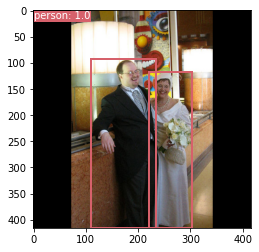

In [7]:
test()

# Model


In [8]:
import torch
import torch.nn as nn

# tuple: (out_channels, kernel_size, stride)
# Dict : {'B': 'residual block', 'S': 'scale prediction', 'U': 'up-sampling'}
config = [
    (32, 3, 1),
    (64, 3, 2),
    ['B', 1],
    (128, 3, 2),
    ['B', 2],
    (256, 3, 2),
    ['B', 8],
    (512, 3, 2),
    ['B', 8],
    (1024, 3, 2),
    ['B', 4],  # To this point is Darknet-53
    (512, 1, 1),
    (1024, 3, 1),
    'S',
    (256, 1, 1),
    'U',
    (256, 1, 1),
    (512, 3, 1),
    'S',
    (128, 1, 1),
    'U',
    (128, 1, 1),
    (256, 3, 1),
    'S'
]


class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, bn_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=not bn_act, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky = nn.LeakyReLU(.1)
        self.use_bn_act = bn_act

    def forward(self, x):
        if self.use_bn_act:
            return self.leaky(self.bn(self.conv(x)))
        else:
            return self.conv(x)


class ResidualBlock(nn.Module):
    def __init__(self, channels, use_residual=True, num_repeats=1):
        super().__init__()
        self.layers = nn.ModuleList()
        for _ in range(num_repeats):
            self.layers += [
                nn.Sequential(
                    CNNBlock(channels, channels//2, kernel_size=1),
                    CNNBlock(channels//2, channels, kernel_size=3, padding=1)
                )
            ]

        self.use_residual = use_residual
        self.num_repeats = num_repeats

    def forward(self, x):
        for layer in self.layers:
            x = layer(x) + x if self.use_residual else layer(x)

        return x


class ScalePrediciton(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.pred = nn.Sequential(
            CNNBlock(in_channels, 2*in_channels, kernel_size=3, padding=1),
            CNNBlock(2*in_channels, (num_classes + 5)*3, bn_act=False, kernel_size=1)
        )
        self.num_classes = num_classes

    def forward(self, x):
        # N x 3 x 13 x 13 x 5+num_classes
        return self.pred(x).reshape(x.shape[0], 3, self.num_classes + 5, x.shape[2], x.shape[3]).permute(0, 1, 3, 4, 2)


class YOLOv3(nn.Module):
    def __init__(self, in_channels=3, num_classes=20):
        super().__init__()
        self.num_classes = num_classes
        self.in_channels = in_channels
        self.layers = self._create_conv_layers()

    def forward(self, x):
        outputs = []
        route_connections = []

        for layer in self.layers:
            if isinstance(layer, ScalePrediciton):
                outputs.append(layer(x))
                continue

            x = layer(x)
            
            if isinstance(layer, ResidualBlock) and layer.num_repeats == 8:
                route_connections.append(x)

            elif isinstance(layer, nn.Upsample):
                x = torch.cat([x, route_connections[-1]], dim=1)
                route_connections.pop()

        return outputs

    def _create_conv_layers(self):
        layers = nn.ModuleList()
        in_channels = self.in_channels

        for module in config:
            if isinstance(module, tuple):
                out_channels, kernel_size, stride = module
                layers.append(
                    CNNBlock(
                        in_channels, 
                        out_channels, 
                        kernel_size=kernel_size, 
                        stride=stride, 
                        padding = 1 if kernel_size == 3 else 0
                    )
                )
                in_channels = out_channels

            elif isinstance(module, list):
                num_repeats = module[1]
                layers.append(ResidualBlock(in_channels, num_repeats=num_repeats))

            elif isinstance(module, str):
                if module == 'S':
                    layers += [
                        ResidualBlock(in_channels, use_residual=False, num_repeats=1),
                        CNNBlock(in_channels, in_channels//2, kernel_size=1),
                        ScalePrediciton(in_channels//2, num_classes=self.num_classes)
                    ]
                    in_channels = in_channels//2
                
                elif module == 'U':
                    layers.append(nn.Upsample(scale_factor=2))
                    in_channels = in_channels * 3
                    
        return layers

# Loss


In [9]:
import torch
import torch.nn as nn


class YoloLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        self.bce = nn.BCEWithLogitsLoss()
        self.entropy = nn.CrossEntropyLoss()
        self.sigmoid = nn.Sigmoid()

        # Constants
        self.lambda_class = 1
        self.lambda_noobj = 10
        self.lambda_obj = 1
        self.lambda_box = 10

    def forward(self, predictions, target, anchors):
        obj = target[..., 0] == 1
        noobj = target[..., 0] == 0

        # No obj loss
        no_object_loss = self.bce((predictions[..., 0:1][noobj]), (target[..., 0:1][noobj]))

        # Object loss
        anchors = anchors.reshape(1, 3, 1, 1, 2)  # p_w * exp(t_w)
        box_preds = torch.cat([self.sigmoid(predictions[..., 1:3]), torch.exp(predictions[..., 3:5]) * anchors], dim=-1)
        ious = intersection_over_union(box_preds[obj], target[..., 1:5][obj]).detach()
        object_loss = self.bce((predictions[..., 0:1][obj]), (ious * target[..., 0:1][obj]))

        # Box coordinate Loss
        predictions[..., 1:3] = self.sigmoid(predictions[..., 1:3])  # x, y to be between [0, 1]
        target[..., 3:5] = torch.log((1e-16 + target[..., 3:5] / anchors))
        box_loss = self.mse(predictions[..., 1:5][obj], target[..., 1:5][obj])

        # Class loss
        class_loss = self.entropy((predictions[..., 5:][obj]), (target[..., 5][obj].long()))

        return (
            self.lambda_noobj * no_object_loss
            + self.lambda_obj * object_loss
            + self.lambda_box * box_loss
            + self.lambda_class * class_loss
        )

# Train

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm

torch.backends.cudnn.benchmark = True


def train_fn(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors):
    loop = tqdm(train_loader, leave=True)
    losses=[]

    for batch_idx, (x, y) in enumerate(loop):
        x = x.to(DEVICE)
        y0, y1, y2 = (
            y[0].to(DEVICE),
            y[1].to(DEVICE),
            y[2].to(DEVICE)
        )

        with torch.cuda.amp.autocast():
            out = model(x)
            loss = (
                loss_fn(out[0], y0, scaled_anchors[0])
                + loss_fn(out[1], y1, scaled_anchors[1])
                + loss_fn(out[2], y2, scaled_anchors[2])
            )

        losses.append(loss.item())
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update progress bar
        mean_loss = sum(losses) / len(losses)
        loop.set_postfix(loss=mean_loss)


def main():
    model = YOLOv3(num_classes=NUM_CLASSES).to(DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY,
    )

    loss_fn = YoloLoss()
    scaler = torch.cuda.amp.GradScaler()

    train_loader, test_loader, train_eval_dataset = get_loaders(
        train_csv_path=DATASET+'/train.csv',
        test_csv_path=DATASET+'/test.csv'
    )

    if LOAD_MODEL:
        load_checkpoint(
            model, optimizer, LEARNING_RATE, LOAD_FILE,
        )

    scaled_anchors = (
        torch.tensor(ANCHORS)
        * torch.tensor(config_S).unsqueeze(1).unsqueeze(2).repeat(1, 3, 2)
    ).to(DEVICE)

    for epoch in range(NUM_EPOCHS):
        train_fn(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors)

        if (epoch + 1) % 10 == 0 and epoch > 0:
            if SAVE_MODEL:
                save_checkpoint(model, optimizer)
                
            print('On Test Loader')
            check_class_accuracy(model, test_loader, CONF_THRESHOLD) 

            pred_boxes, true_boxes = get_evaluation_bboxes(
                test_loader,
                model,
                iou_threshold=NMS_IOU_THRESH,
                anchors=ANCHORS,
                threshold=CONF_THRESHOLD,
            )
            mapval = mean_average_precision(
                pred_boxes,
                true_boxes,
                iou_threshold=MAP_IOU_THRESH,
                box_format='midpoint',
                num_classes=NUM_CLASSES,
            )
            print(f'MAP: {mapval.item()}')
            
main()

==> Loading checkpoint


100%|██████████| 1035/1035 [07:47<00:00,  2.21it/s, loss=4.29]


==> Saving checkpoint


  0%|          | 0/310 [00:00<?, ?it/s]

On Test Loader


  0%|          | 0/310 [00:00<?, ?it/s]

Class accuracy is: 0.291871%
No obj accuracy is: 99.097565%
Obj accuracy is: 60.657566%


  0%|          | 0/1035 [00:00<?, ?it/s]

MAP: 0.3717206120491028


100%|██████████| 1035/1035 [07:55<00:00,  2.18it/s, loss=3.97]


==> Saving checkpoint


  0%|          | 0/310 [00:00<?, ?it/s]

On Test Loader


  0%|          | 0/310 [00:00<?, ?it/s]

Class accuracy is: 0.240364%
No obj accuracy is: 99.228294%
Obj accuracy is: 59.035110%


  0%|          | 0/1035 [00:00<?, ?it/s]

MAP: 0.3714524209499359


100%|██████████| 1035/1035 [07:53<00:00,  2.19it/s, loss=3.77]


==> Saving checkpoint


  0%|          | 0/310 [00:00<?, ?it/s]

On Test Loader


  0%|          | 0/310 [00:00<?, ?it/s]

Class accuracy is: 0.266117%
No obj accuracy is: 99.237976%
Obj accuracy is: 59.223969%


  0%|          | 0/1035 [00:00<?, ?it/s]

MAP: 0.3890570402145386


100%|██████████| 1035/1035 [07:56<00:00,  2.17it/s, loss=3.59]


==> Saving checkpoint


  0%|          | 0/310 [00:00<?, ?it/s]

On Test Loader


  0%|          | 0/310 [00:00<?, ?it/s]

Class accuracy is: 0.240364%
No obj accuracy is: 99.240135%
Obj accuracy is: 58.803333%


  0%|          | 0/1035 [00:00<?, ?it/s]

MAP: 0.38454967737197876


100%|██████████| 1035/1035 [07:48<00:00,  2.21it/s, loss=3.43]


==> Saving checkpoint


  0%|          | 0/310 [00:00<?, ?it/s]

On Test Loader


  0%|          | 0/310 [00:00<?, ?it/s]

Class accuracy is: 0.274702%
No obj accuracy is: 99.380341%
Obj accuracy is: 56.657227%


  0%|          | 0/1035 [00:00<?, ?it/s]

MAP: 0.40148037672042847


100%|██████████| 1035/1035 [07:49<00:00,  2.21it/s, loss=3.3]


==> Saving checkpoint


  0%|          | 0/310 [00:00<?, ?it/s]

On Test Loader


  0%|          | 0/310 [00:00<?, ?it/s]

Class accuracy is: 0.257533%
No obj accuracy is: 99.382278%
Obj accuracy is: 57.412655%


  0%|          | 0/1035 [00:00<?, ?it/s]

MAP: 0.3890874683856964


100%|██████████| 1035/1035 [07:53<00:00,  2.19it/s, loss=3.28]
